# Longitudinal Fitting

Developed bulge, interpolation, etc functions. Eventually these were incorporated into contour.py

In [1]:
import importlib
import confocal
importlib.reload(confocal)

import glob, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio
import re
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.measurements import center_of_mass
from scipy.interpolate import interp2d,RegularGridInterpolator
from random import random
from tqdm import tqdm
from scipy.interpolate import interp1d
import cv2

from itertools import accumulate
from skimage.measure import find_contours
from scipy.spatial import ConvexHull
import time

import itertools
from copy import deepcopy

In [2]:
import contour
%matplotlib inline

## Load files

In [47]:
celln = 2
npts = 20

# output_folder="export_contours/test_HUVEC1_I%d" % celln
annotation_folder='datasets/SR_HUVEC1/HUVEC Cell %d/annotation' % celln
# input_folder = "export_contours/test_HUVEC1_P%d" % celln

envelope_nucleus = contour.convert_annotated(annotation_folder, 'nucleus_linear3D')
envelope_cyto = contour.convert_annotated(annotation_folder, 'cyto_linear3D')
envelope_other = contour.convert_annotated(annotation_folder, 'other_linear3D')

ee = deepcopy(envelope_cyto)
ne = deepcopy(envelope_nucleus) if len(envelope_nucleus) else deepcopy(envelope_other)

# Find center of mass at top:
last_level = list(sorted(ne.keys()))[-1]
print('Last level polygon:', ne[last_level])
rows = ne[last_level][:2].T.astype(np.float32)
M = cv2.moments(rows)
recentering = M["m10"] / M["m00"], M["m01"] / M["m00"]
print('Reentered:', recentering)
# raise Exception('stop')

# Calls edit_level on each level, which expands out, and does some other conditioning.
# nuclear envelope included so that cytoplasm is always outside
cyto_padded = contour.reparam_contour4(ee, ne, doPlot=False, padding=None, npts=npts, recentering=recentering)
# no such req for nucleus itself
nuc_padded = contour.reparam_contour4(ne, None, doPlot=False, padding=None, npts=npts, recentering=recentering)


100%|██████████| 34/34 [00:00<00:00, 473.33it/s]
0it [00:00, ?it/s]


Last level polygon: [[656.93442623 643.81967213 635.62295082 658.57377049 660.21311475]
 [577.         595.03278689 616.3442623  629.45901639 606.50819672]]
Reentered: (650.6313888880464, 606.2681804074846)


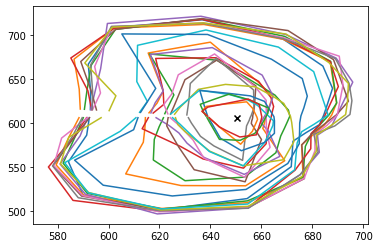

In [48]:
for level in nuc_padded:
#     print(nuc_padded[level])
    plt.plot(nuc_padded[level][0],nuc_padded[level][1])
#     break
plt.scatter(recentering[0], recentering[1], marker='x', color='k')

## Define smoothing functions

In [49]:
# Smooth using moving average. Allows smoothing in logspace, but we don't use it
def smoothed(r, window=3, use_log=False):
    
    if use_log: r = np.log(r)
    res = np.convolve(r, np.ones(window), 'same') / np.convolve(r*0+1, np.ones(window),'same')
    if use_log: res = np.exp(res)
    
    return res

# Interpolate and enforce some monotonicity in the values of along a polar ray
def make10_nondec(r, levels, n=10, levels_predicted=None, do_smooth=True, nondec=True, minmax='min', 
                  trim=True, guide=None):
        
    if levels_predicted is None: 
        levels_predicted = np.linspace(levels[0], levels[-1],10)

    if do_smooth: r = smoothed(r, window=3) # apply moving average
    
    r_predicted = np.interp(levels_predicted, levels, r, left=None, right=None)
    
    if nondec: 
        r_predicted = np.minimum.accumulate(r_predicted) if minmax == 'min' else np.maximum.accumulate(r_predicted)
        
    return levels_predicted, r_predicted

# Use a guide line to provide a minimum r for each level
# This function tries to interpolate the guide line so no sharp features go unmissed
def bulge2(r1,z1,r2,z2,scaling, bb=.020, debug=False):
    
    if scaling is None: scaling = (0.07285744510047523, 0.07285744510047523, 0.1)


    newz, newr = [], []

    zgi = np.linspace(min(z2), max(z2),101)
    rgi = np.interp(zgi, z2,r2)
    
    zoi = np.linspace(min(z1), max(z1), 101)
    roi = np.interp(zoi, z1, r1)
    
    for z, r in zip(zoi,roi): # for each outer point, displaced by rp
        rp = 0
        
        dist = np.array([np.sqrt((r+rp-rg)**2*scaling[0]**2+(z-zg)**2*scaling[-1]**2) for zg,rg in zip(zgi,rgi)])
        ginterpdr = np.interp([z], z2,r2)[0]
        
        while(min(dist)<bb or r+rp < ginterpdr):
            rp+=0.25
            dist = np.array([np.sqrt((r+rp-rg)**2*scaling[0]**2+(z-zg)**2*scaling[-1]**2) for zg,rg in zip(zgi,rgi)])
      
        
        if debug: print(z,r,rp,min(dist))
        
        newz.append(z)
        newr.append(r+rp)
        
    newzi = np.linspace(newz[0], newz[-1], 10)
    newri = np.interp(newzi, newz, newr )
    return newzi, newri
    return newz, newr

# r1 is cyto, r2 is nucleus (guide)
def bulge(r1,z1,r2,z2,scaling, bb=.020, debug=False):
    
    if scaling is None: scaling = (0.07285744510047523, 0.07285744510047523, 0.1)

    newz, newr = [], []
    
    for z, r in zip(z1,r1): # for each outer point, displaced by rp
        
        ginterpdr = np.interp([z], z2,r2)[0]
        
        rp = max(r, ginterpdr + bb)
                    
        newz.append(z)
        newr.append(rp)
        
    newzi = np.linspace(newz[0], newz[-1], 10)
    newri = np.interp(newzi, newz, newr )
    return newzi, newri
    return newz, newr


## Post-process linecuts

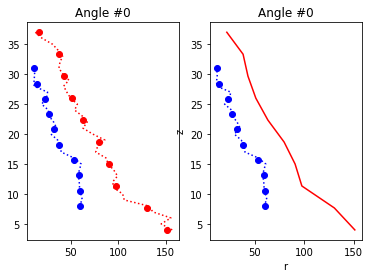

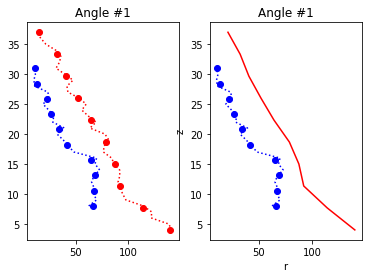

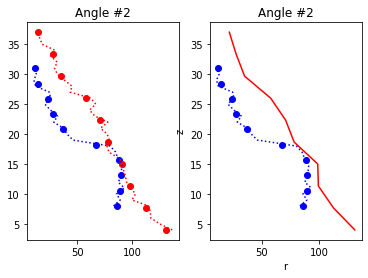

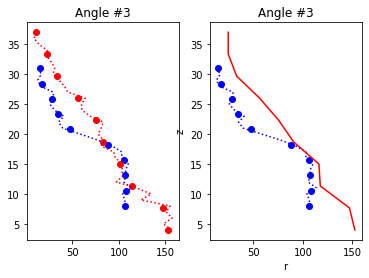

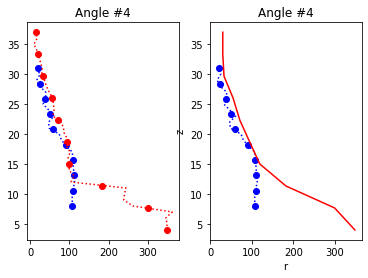

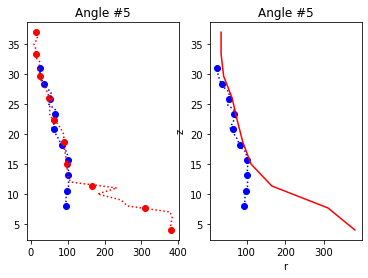

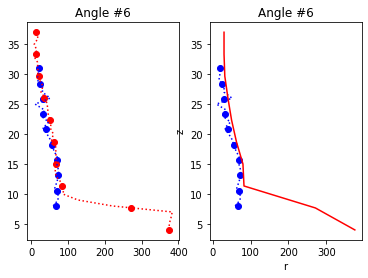

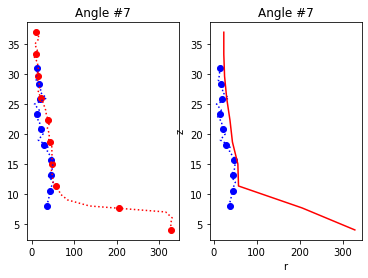

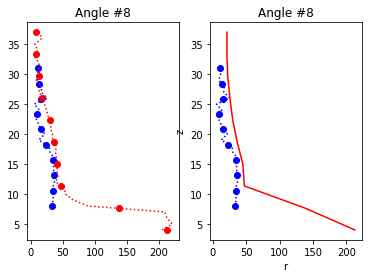

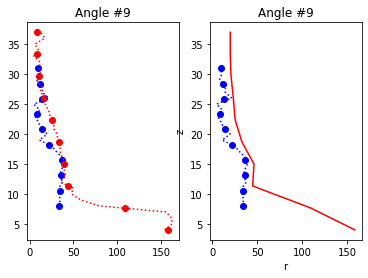

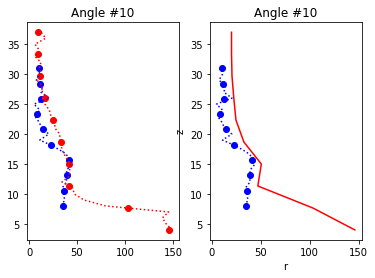

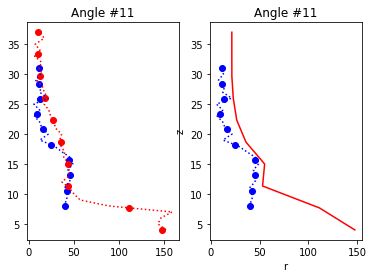

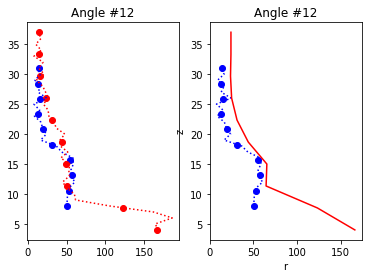

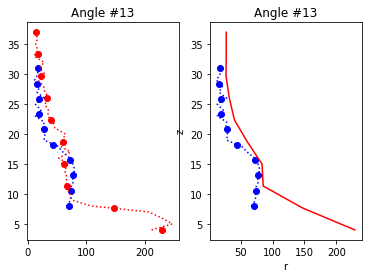

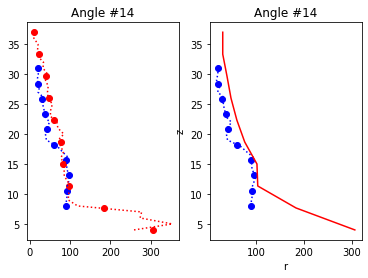

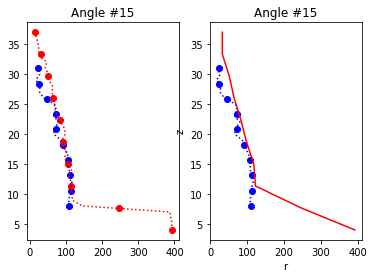

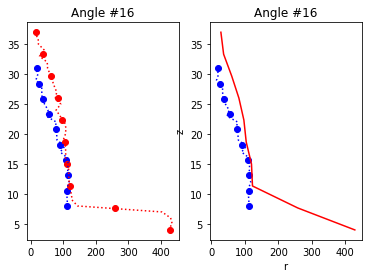

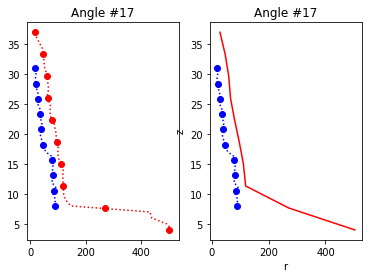

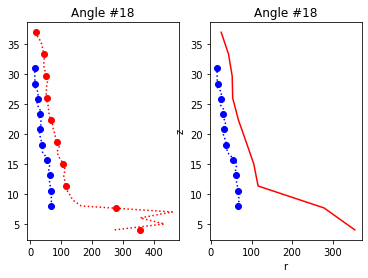

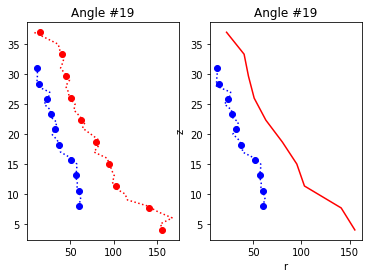

In [50]:
def pplinecuts(nuc_padded, cyto_padded, recentering, nangles=20, nlevs=10, bb=10, doPlot=False):
        
    new_nuc = []
    new_cyto = []
    # Conver plotting to side-by-side comparison
    for polar_anglen in range(nangles): # shouldn't hardcode number
        
        levs = sorted(nuc_padded.keys())    
        desired_levels = np.linspace(levs[0], levs[-1], nlevs) # shouldn't hardcode number
        desired_levels = [round(_,2) for _ in desired_levels]

        x = np.array([nuc_padded[lev][0][polar_anglen] - recentering[0] for lev in levs])
        y = np.array([nuc_padded[lev][1][polar_anglen] - recentering[1] for lev in levs])
    #     plt.plot(x,y)

        levsp, rpp = make10_nondec(np.sqrt(x**2 + y**2), levs, levels_predicted=desired_levels, do_smooth=True, nondec=False)
        levspg, rppg = levsp, rpp # save as guide
        
        new_nuc.append([levsp, rpp])

        if doPlot:
            fig, axs = plt.subplots(1,2)

            ax0, ax1 = axs

            ax0.scatter(rpp,levsp, color='blue')
            ax0.plot(np.sqrt(x**2 + y**2),levs, color='blue', linestyle=':')
            ax0.set_title('Angle #%d' % polar_anglen)
        #   

            ax1.scatter(rpp,levsp, color='blue')
            ax1.plot(np.sqrt(x**2 + y**2),levs, color='blue', linestyle=':')
            ax1.set_title('Angle #%d' % polar_anglen)
        #     plt.show()

        levs = sorted(cyto_padded.keys())    
        desired_levels = np.linspace(levs[0], levs[-1], nlevs)
        desired_levels = [round(_,2) for _ in desired_levels]

        x = np.array([cyto_padded[lev][0][polar_anglen] - recentering[0] for lev in levs])
        y = np.array([cyto_padded[lev][1][polar_anglen] - recentering[1] for lev in levs])
    #     plt.plot(x,y)

        levsp, rpp = make10_nondec(np.sqrt(x**2 + y**2), levs, levels_predicted=desired_levels, do_smooth=True)
    #     levspg, rppg = levsp, rpp # save as guide
    
        if doPlot:
            ax0.scatter(rpp,levsp, color='red')
            ax0.plot(np.sqrt(x**2 + y**2),levs, color='red', linestyle=':')

        levspb, rppb = bulge(rpp, levsp, rppg,levspg, scaling=None,bb=bb)
        
        new_cyto.append([levspb, rppb])



        if doPlot:
    #         plt.scatter(rpp,levsp, color='red')


    #         plt.plot(np.sqrt(x**2 + y**2),levs, color='red',linestyle=':')
            ax1.plot(rppb, levspb, color='red') #,linestyle=':')

            #     plt.xscale('log')

            ax1.set_xlabel('r')
            ax1.set_ylabel('z')
            
    
            
    return np.array(new_nuc).transpose(1,2,0), np.array(new_cyto).transpose(1,2,0)

# returns objects to xy space dicts
def re_xy(obj):
#     print(obj.shape, )
    obj_r = {obj[0,ii,0]: obj[1,ii,:] for ii in range(obj.shape[1])}
    
    th = np.linspace(-np.pi, np.pi - np.pi / npts, npts)

    obj_xy = {
        obj[0,ii,0]: np.array([
                obj[1,ii,:]*np.cos(th), 
                obj[1,ii,:]*np.sin(th)]) 
            for ii in range(obj.shape[1])
    } # cXg + r0g * np.cos(t0g), cYg + r0g * np.sin(t0g)

    return obj_xy
    
            
nn, nc = pplinecuts(nuc_padded, cyto_padded, recentering=recentering, doPlot=True)
nn, nc = re_xy(nn), re_xy(nc)

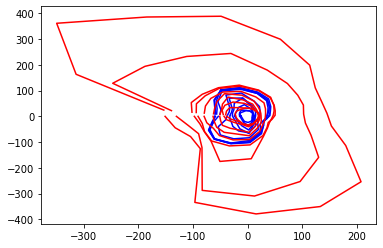

In [54]:
for _ in nn:
    plt.plot(nn[_][0], nn[_][1], color='blue')
for _ in nc:
    plt.plot(nc[_][0], nc[_][1], color='red')

In [ ]:
# What's to be done?
# . Copy functions into library files
# . Invoke new functions in rendering script
# . Double-check extra Z handling -- decimation, or caps, etc